In [1]:
# 04_indicators_analysis.ipynb - Προσθήκη Τεχνικών Δεικτών

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Φόρτωση καθαρών δεδομένων ---
df_1h = pd.read_csv('../data/XAU_1h_clean.csv', index_col='Date', parse_dates=True)
df_1d = pd.read_csv('../data/XAU_1d_clean.csv', index_col='Date', parse_dates=True)




In [2]:
# --- 1. Moving Averages ---
for df in [df_1d, df_1h]:
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_100'] = df['Close'].rolling(window=100).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['EMA_100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()


In [3]:
# --- 2. Relative Strength Index (RSI) ---
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_1d['RSI_14'] = compute_rsi(df_1d['Close'])
df_1h['RSI_14'] = compute_rsi(df_1h['Close'])




In [4]:
# --- 4. Bollinger Bands & ATR ---
for df in [df_1d, df_1h]:
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']

    df['TR'] = df['High'] - df['Low']
    df['ATR_14'] = df['TR'].rolling(window=14).mean()


In [5]:
# --- 5. Signals (EMA20 > EMA50 => Buy / Sell) ---
for df in [df_1d, df_1h]:
    df['Signal'] = 0
    df.loc[df['EMA_20'] > df['EMA_50'], 'Signal'] = 1
    df.loc[df['EMA_20'] < df['EMA_50'], 'Signal'] = -1

In [6]:
# --- 3. MACD Indicator ---
for df in [df_1d, df_1h]:
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()


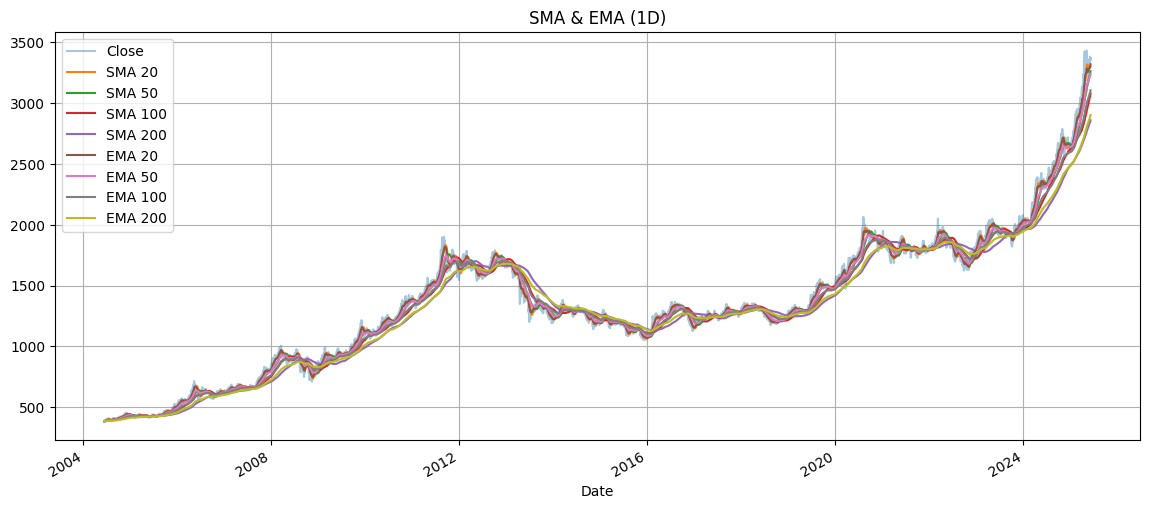

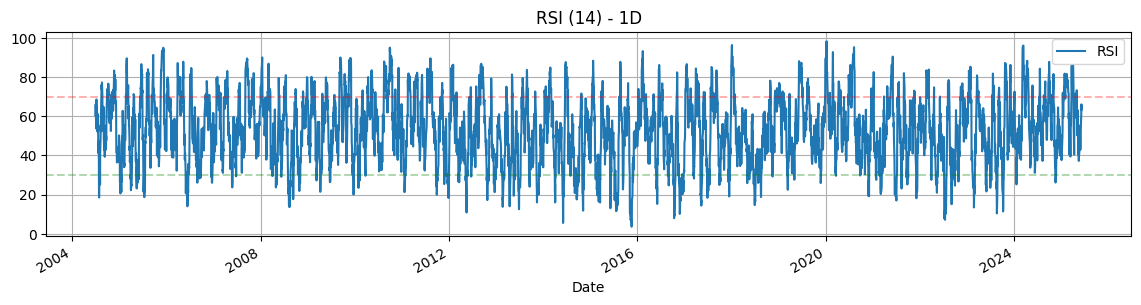

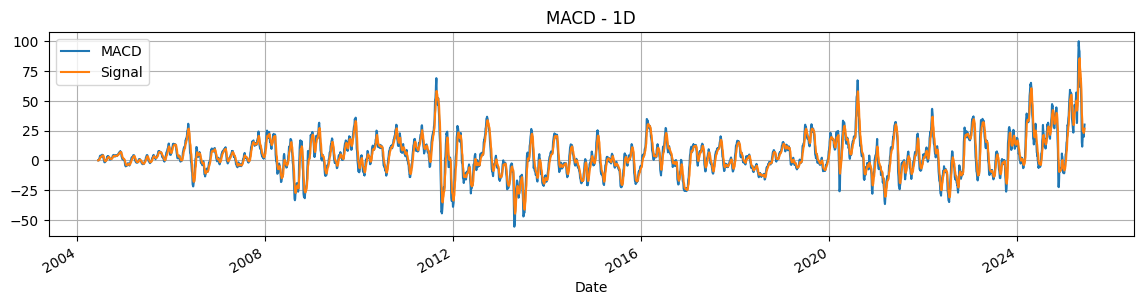

In [7]:
# --- 4. Οπτικοποίηση Δεικτών ---
plt.figure(figsize=(14,6))
df_1d['Close'].plot(label='Close', alpha=0.4)
df_1d['SMA_20'].plot(label='SMA 20')
df_1d['SMA_50'].plot(label='SMA 50')
df_1d['SMA_100'].plot(label='SMA 100')
df_1d['SMA_200'].plot(label='SMA 200')
df_1d['EMA_20'].plot(label='EMA 20')
df_1d['EMA_50'].plot(label='EMA 50')
df_1d['EMA_100'].plot(label='EMA 100')
df_1d['EMA_200'].plot(label='EMA 200')
plt.title('SMA & EMA (1D)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,3))
df_1d['RSI_14'].plot(label='RSI')
plt.axhline(70, color='red', linestyle='--', alpha=0.3)
plt.axhline(30, color='green', linestyle='--', alpha=0.3)
plt.title('RSI (14) - 1D')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,3))
df_1d['MACD'].plot(label='MACD')
df_1d['MACD_Signal'].plot(label='Signal')
plt.title('MACD - 1D')
plt.grid(True)
plt.legend()
plt.show()



In [8]:
# --- 5. Αποθήκευση εμπλουτισμένων δεδομένων ---
df_1d.to_csv('../data/XAU_1d_with_indicators.csv')
df_1h.to_csv('../data/XAU_1h_with_indicators.csv')


In [9]:
# --- 6. Backtesting Strategy (equity curve) ---
for df in [df_1d, df_1h]:
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df['Signal'].shift(1) * df['Return']
    df['Equity'] = (1 + df['Strategy_Return']).cumprod()


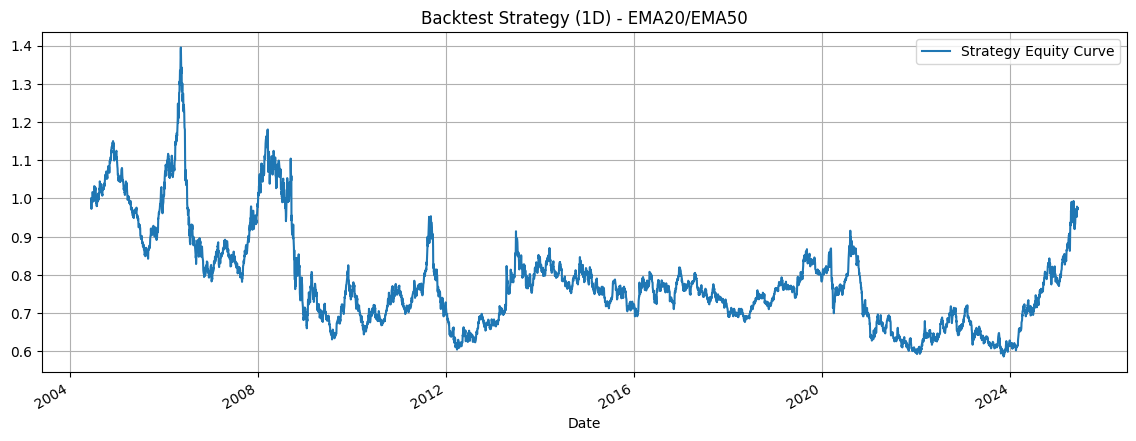

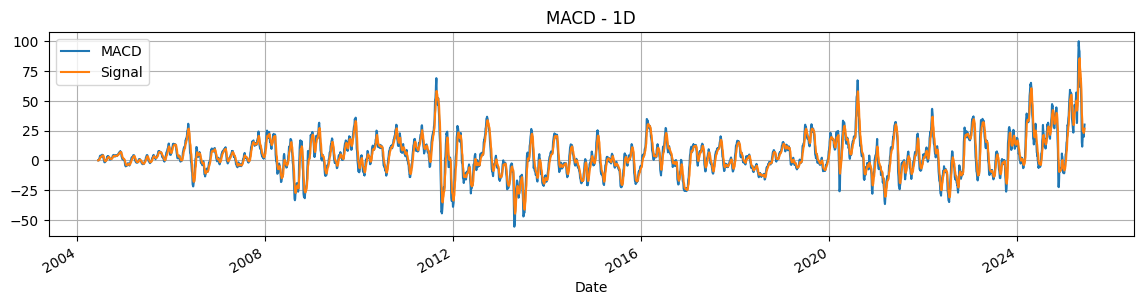

In [12]:
# --- 7. Οπτικοποίηση Απόδοσης Στρατηγικής (1D) ---
plt.figure(figsize=(14,5))
df_1d['Equity'].plot(label='Strategy Equity Curve')
plt.title('Backtest Strategy (1D) - EMA20/EMA50')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,3))
df_1d['MACD'].plot(label='MACD')
df_1d['MACD_Signal'].plot(label='Signal')
plt.title('MACD - 1D')
plt.grid(True)
plt.legend()
plt.show()